In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV

# Feature pre-processing
#### Numerical Features
'id', 'scrape_id', 'host_id', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 
'host_total_listings_count','latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price',
'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews',
'number_of_reviews_ltm','number_of_reviews_l30d','review_scores_rating','review_scores_accuracy',
'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
'review_scores_value','calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms','reviews_per_month'

#### Categorical Features
'source', 'host_response_time', 'host_is_superhost', 'host_neighbourhood', 'host_has_profile_pic', 
'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 
'property_type','room_type', 'has_availability', 'instant_bookable', 'host_location'

#### Date Features
'last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review'

#### Text Features
'listing_url', 'name', 'description', 'neighbourhood_overview', 'picture_url', 
'host_url', 'host_name', 'host_about', 'hosr_thumbnail_url', 'host_picture_url', 
'host_verifications', 'bathrooms_text', 'amenities'

#### Empty Columns
'calendar_updated', 'bathrooms'

#### Dummu Column
'license'

In [2]:
data = pd.read_csv('listings.csv')
airbnb = pd.read_csv('airbnb_4.csv')
# Merge the two dataframes based on the 'id' column, concatenate 3 new features
merged_df = pd.merge(data, airbnb[['id', 'average_nearest_price', 'within_radius', 'bus_radius']], on='id')

In [3]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4887 entries, 0 to 4886
Data columns (total 78 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4887 non-null   int64  
 1   listing_url                                   4887 non-null   object 
 2   scrape_id                                     4887 non-null   int64  
 3   last_scraped                                  4887 non-null   object 
 4   source                                        4887 non-null   object 
 5   name                                          4887 non-null   object 
 6   description                                   4866 non-null   object 
 7   neighborhood_overview                         3422 non-null   object 
 8   picture_url                                   4887 non-null   object 
 9   host_id                                       4887 non-null   i

### Since we face to new host, we select the features that is relevant to the feature price, ignored empty columns, identification features (id, name, etc.), high correlated featurs (host_listings_count, minimum_minimum_nights, etc), and past experience features, etc.

In [4]:
# 22 selected features
columns = ['latitude', 'longitude', 'host_total_listings_count','host_has_profile_pic', 
           'host_identity_verified','neighbourhood_cleansed', 'property_type', 'room_type', 
           'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 
           'maximum_nights', 'has_availability', 'instant_bookable', 'calculated_host_listings_count', 
            'average_nearest_price', 'within_radius', 'bus_radius']
df = merged_df[columns].copy()

# Data Pre-processing

### 1. Count the number of NA in each column, and drop all rows have NA.

In [5]:
def count_na_by_column(data):
    for column in data.columns:
        print(column + ":", data[column].isna().sum())
count_na_by_column(df)
df = df.dropna()

latitude: 0
longitude: 0
host_total_listings_count: 0
host_has_profile_pic: 0
host_identity_verified: 0
neighbourhood_cleansed: 0
property_type: 0
room_type: 0
accommodates: 0
bathrooms_text: 2
bedrooms: 299
beds: 44
amenities: 0
price: 0
minimum_nights: 0
maximum_nights: 0
has_availability: 0
instant_bookable: 0
calculated_host_listings_count: 0
average_nearest_price: 5
within_radius: 0
bus_radius: 0


In [6]:
df.isnull().sum()

latitude                          0
longitude                         0
host_total_listings_count         0
host_has_profile_pic              0
host_identity_verified            0
neighbourhood_cleansed            0
property_type                     0
room_type                         0
accommodates                      0
bathrooms_text                    0
bedrooms                          0
beds                              0
amenities                         0
price                             0
minimum_nights                    0
maximum_nights                    0
has_availability                  0
instant_bookable                  0
calculated_host_listings_count    0
average_nearest_price             0
within_radius                     0
bus_radius                        0
dtype: int64

### 2. Convert the price to numeric values [extreme value removed]

In [7]:
def prices_to_numbers (price_string):
    price_numeric = float(str(price_string).replace(',', '').split('$')[-1])
    return price_numeric
df['price'] = df['price'].apply(prices_to_numbers)
df.price.head(2)

0    157.0
1    150.0
Name: price, dtype: float64

In [8]:
q_high = df['price'].quantile(0.95)
q_low = df['price'].quantile(0.05)
df = df[(df['price'] <= q_high) & (df['price'] >= q_low)]

### 3. Convert bool value to numeric.

In [9]:
from sklearn.preprocessing import LabelEncoder
boolean_cols = ['host_has_profile_pic',
               'host_identity_verified',
               'has_availability',
               'instant_bookable',
               'within_radius',
               'bus_radius']

le = LabelEncoder()

for col in boolean_cols:
    col_encoded = le.fit_transform(df[col])
    df[col] = le.fit_transform(df[col])
df.head(2)

,latitude,longitude,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_text,...,amenities,price,minimum_nights,maximum_nights,has_availability,instant_bookable,calculated_host_listings_count,average_nearest_price,within_radius,bus_radius
0,49.28201,-123.12669,1,1,1,West End,Entire condo,Entire home/apt,2,1 bath,...,"[""Freezer"", ""Heating"", ""Toaster"", ""Extra pillo...",157.0,2,90,1,0,1,594340.0,1,1
1,49.25622,-123.06607,5,1,1,Kensington-Cedar Cottage,Entire rental unit,Entire home/apt,2,1 bath,...,"[""Freezer"", ""Books and reading material"", ""Pri...",150.0,30,180,1,0,1,1478380.0,1,0


### 4. Extract all kind of amenities from the text, create new amenity boolean features.

In [10]:
all_amenities = []
amenities_list = df.amenities.unique()

for i in range(len(amenities_list)):
    amenities = amenities_list[i].split(",")
    for ft in amenities:
        for amen in ft.split('"'):
            if amen != "[" and amen != "]" and amen not in all_amenities:
                all_amenities.append(amen)

We manually selected a few hot amenities to create new boolean features.

In [11]:
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
#df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

C:\Users\kewei\AppData\Local\Temp\ipykernel_9600\2902660134.py:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4095 entries, 0 to 4886
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        4095 non-null   float64
 1   longitude                       4095 non-null   float64
 2   host_total_listings_count       4095 non-null   int64  
 3   host_has_profile_pic            4095 non-null   int32  
 4   host_identity_verified          4095 non-null   int32  
 5   neighbourhood_cleansed          4095 non-null   object 
 6   property_type                   4095 non-null   object 
 7   room_type                       4095 non-null   object 
 8   accommodates                    4095 non-null   int64  
 9   bathrooms_text                  4095 non-null   object 
 10  bedrooms                        4095 non-null   float64
 11  beds                            4095 non-null   float64
 12  amenities                       40

Replacing nulls with zeros for new columns

In [13]:
cols_to_replace_nulls = df.iloc[:,22:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

Next, we view the value set for all new columns

In [14]:
def printValuesForEachColumn(data):
    for amenity_column in data.columns[22:]:
        print(amenity_column, set(data[amenity_column]))
printValuesForEachColumn(df)

air_conditioning {0.0, 1.0}
high_end_electronics {0.0, 1.0}
bbq {0.0, 1.0}
balcony {0.0, 1.0}
nature_and_views {0.0, 1.0}
bed_linen {0.0, 1.0}
breakfast {0.0, 1.0}
tv {0.0, 1.0}
coffee_machine {0.0, 1.0}
cooking_basics {0.0, 1.0}
white_goods {0.0, 1.0}
elevator {0.0, 1.0}
gym {0.0, 1.0}
child_friendly {0.0, 1.0}
parking {0.0, 1.0}
outdoor_space {0.0, 1.0}
host_greeting {0.0, 1.0}
hot_tub_sauna_or_pool {0.0, 1.0}
internet {0.0, 1.0}
long_term_stays {0.0, 1.0}
pets_allowed {0.0, 1.0}
private_entrance {0.0, 1.0}
secure {0.0, 1.0}
smoking_allowed {0.0, 1.0}


We did not observe any column contains a single value only.

Dropping the original amenities column

In [15]:
df.drop('amenities', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4095 entries, 0 to 4886
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        4095 non-null   float64
 1   longitude                       4095 non-null   float64
 2   host_total_listings_count       4095 non-null   int64  
 3   host_has_profile_pic            4095 non-null   int32  
 4   host_identity_verified          4095 non-null   int32  
 5   neighbourhood_cleansed          4095 non-null   object 
 6   property_type                   4095 non-null   object 
 7   room_type                       4095 non-null   object 
 8   accommodates                    4095 non-null   int64  
 9   bathrooms_text                  4095 non-null   object 
 10  bedrooms                        4095 non-null   float64
 11  beds                            4095 non-null   float64
 12  price                           40

### 5. Displays the property type of listings

In [16]:
property_type_counts = df.property_type.value_counts()
property_type_counts

Entire condo                          1189
Entire rental unit                     792
Entire home                            634
Entire guest suite                     545
Private room in home                   319
Entire loft                            119
Entire townhouse                        80
Private room in rental unit             70
Private room in condo                   65
Entire guesthouse                       62
Entire serviced apartment               57
Private room in villa                   27
Private room in townhouse               23
Private room in guest suite             16
Entire villa                            11
Entire bungalow                         10
Room in boutique hotel                   9
Private room in bed and breakfast        8
Entire place                             6
Room in aparthotel                       5
Private room in bungalow                 4
Entire timeshare                         4
Entire cottage                           4
Private roo

Grouping property types whose low counts might be insignificant and not provide us with enough information.
Thus, grouping property types that have counts that are < 20 into 'Other'.

In [17]:
df.loc[df.property_type.isin(property_type_counts[property_type_counts<20].keys()), 'property_type'] = 'Other'
df.property_type.value_counts()

Entire condo                   1189
Entire rental unit              792
Entire home                     634
Entire guest suite              545
Private room in home            319
Entire loft                     119
Other                           113
Entire townhouse                 80
Private room in rental unit      70
Private room in condo            65
Entire guesthouse                62
Entire serviced apartment        57
Private room in villa            27
Private room in townhouse        23
Name: property_type, dtype: int64

### 6. Extract the features of bathrooms number and bathroom type from the text column 'bathrooms_text'

In [18]:
list(set(df.bathrooms_text))[0:10]

['2 shared baths',
 '4 baths',
 '1 shared bath',
 '2.5 baths',
 'Shared half-bath',
 '0 shared baths',
 '1 bath',
 '6 baths',
 '3 baths',
 '3 shared baths']

In [19]:
def convertBathrooms(row):  
    if 'private' in row['bathrooms_text'].lower():
        return 'private'
    elif 'shared' in row['bathrooms_text'].lower():
        return 'shared'
    return 'unknown'

df['bathrooms_type'] = df.apply(lambda row: convertBathrooms(row), axis=1)
df.bathrooms_type.value_counts()

unknown    3587
private     254
shared      254
Name: bathrooms_type, dtype: int64

Now we extract the bathroom number

In [20]:
def calculateBathroomNum(row):  
    if 'half' in row['bathrooms_text'].lower() or 'Half' in row['bathrooms_text'].lower():
        return 0.5
    return float(row['bathrooms_text'].split(" ")[0])

df['bathrooms_number'] = df.apply(lambda row: calculateBathroomNum(row), axis=1)
df.bathrooms_number.value_counts()

1.0    3023
2.0     704
1.5     191
2.5     107
3.0      34
3.5      16
4.0       8
4.5       4
0.0       3
0.5       2
6.0       1
5.0       1
7.0       1
Name: bathrooms_number, dtype: int64

Drop the original column 'bathrooms_text'

In [21]:
df.drop('bathrooms_text', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4095 entries, 0 to 4886
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        4095 non-null   float64
 1   longitude                       4095 non-null   float64
 2   host_total_listings_count       4095 non-null   int64  
 3   host_has_profile_pic            4095 non-null   int32  
 4   host_identity_verified          4095 non-null   int32  
 5   neighbourhood_cleansed          4095 non-null   object 
 6   property_type                   4095 non-null   object 
 7   room_type                       4095 non-null   object 
 8   accommodates                    4095 non-null   int64  
 9   bedrooms                        4095 non-null   float64
 10  beds                            4095 non-null   float64
 11  price                           4095 non-null   float64
 12  minimum_nights                  40

### 7. Encode other categorical features.

In [22]:
boolean_cols = ['neighbourhood_cleansed',
               'property_type',
               'room_type',
               'bathrooms_type']

le = LabelEncoder()

for col in boolean_cols:
    col_encoded = le.fit_transform(df[col])
    df[col] = le.fit_transform(df[col])
    # get the mappings of the encoded values
    mappings = dict(zip(range(len(le.classes_)), le.classes_))

    # print the mappings
    print("Mappings for %s: %s\n" % (col, mappings))

Mappings for neighbourhood_cleansed: {0: 'Arbutus Ridge', 1: 'Downtown', 2: 'Downtown Eastside', 3: 'Dunbar Southlands', 4: 'Fairview', 5: 'Grandview-Woodland', 6: 'Hastings-Sunrise', 7: 'Kensington-Cedar Cottage', 8: 'Kerrisdale', 9: 'Killarney', 10: 'Kitsilano', 11: 'Marpole', 12: 'Mount Pleasant', 13: 'Oakridge', 14: 'Renfrew-Collingwood', 15: 'Riley Park', 16: 'Shaughnessy', 17: 'South Cambie', 18: 'Strathcona', 19: 'Sunset', 20: 'Victoria-Fraserview', 21: 'West End', 22: 'West Point Grey'}

Mappings for property_type: {0: 'Entire condo', 1: 'Entire guest suite', 2: 'Entire guesthouse', 3: 'Entire home', 4: 'Entire loft', 5: 'Entire rental unit', 6: 'Entire serviced apartment', 7: 'Entire townhouse', 8: 'Other', 9: 'Private room in condo', 10: 'Private room in home', 11: 'Private room in rental unit', 12: 'Private room in townhouse', 13: 'Private room in villa'}

Mappings for room_type: {0: 'Entire home/apt', 1: 'Hotel room', 2: 'Private room', 3: 'Shared room'}

Mappings for bathr

## SAVE, Test Data Preprocessing

In [23]:
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1, train_size = 0.9,  random_state=42)

In [24]:
X_train.to_csv('preprocessed_X_train.csv',index=False)
y_train.to_csv('preprocessed_y_train.csv',index=False)
X_test.to_csv('preprocessed_X_test.csv',index=False)
y_test.to_csv('preprocessed_y_test.csv',index=False)


In [25]:
!pip install nbconvert

In [26]:
import subprocess
subprocess.check_call(['jupyter', 'nbconvert', '--to', 'notebook', '--execute', 'feature_patch_1.ipynb'])

0

# Model fitting

Tree regression is a technique that is bale to perform both regression and classification task with decision tree. Since our dataset contains 30+ categorical variables, we choose to use the tree regressor becuase it potentially more friendly with categorical variables.

### Model 1 (No fine tune available)

In [27]:
X_train_1 = X_train
y_train_1 = y_train

X_test_1 = pd.read_csv('preprocessed_2_X_test_1.csv', sep=',')
y_test_1 = pd.read_csv('preprocessed_2_y_test_1.csv', sep=',')
print(len(y_test_1))
regressor = RandomForestRegressor(n_estimators = 40, max_features = 'sqrt', max_depth = 50)
# regressor = GradientBoostingRegressor(random_state=0)
regressor.fit(X_train_1, y_train_1)
y_predict = regressor.predict(X_test_1)

365


In [28]:
importancesRF = regressor.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_1.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
feat_imp1.head(5)

,Weight
bathrooms_number,0.087680
bedrooms,0.081879
latitude,0.073652
longitude,0.070596
accommodates,0.060929


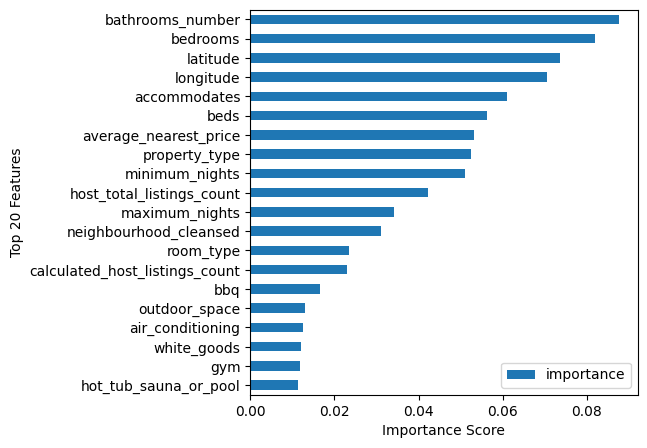

In [29]:
import matplotlib.pyplot as plt
feat_imp = pd.DataFrame({'importance':regressor.feature_importances_})  
feat_imp['feature'] = X_train_1.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)

feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp = feat_imp[25:46]
feat_imp.plot.barh(figsize=(5,5))
plt.xlabel('Importance Score')
plt.ylabel('Top 20 Features')
plt.show()

In [30]:
import math  
import sklearn.metrics
mse = sklearn.metrics.mean_squared_error(y_test_1, y_predict)  
mae = sklearn.metrics.mean_absolute_error(y_test_1, y_predict) 

rmse = math.sqrt(mse)  

# print("r2 score = ", regressor.score(X_test,y_test))
print("RMSE = ", rmse)
print("MAE = ", mae)

RMSE =  53.50017139401588
MAE =  40.329048706240485


In [31]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test_1)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

### Model 2 (fine tune availiable)

In [32]:
X_test_2 = pd.read_csv('preprocessed_2_X_test_2.csv', sep=',')
y_test_2 = pd.read_csv('preprocessed_2_y_test_2.csv', sep=',')
X_train_2 = pd.read_csv('preprocessed_2_X_train.csv', sep=',')
y_train_2 = pd.read_csv('preprocessed_2_y_train.csv', sep=',')
print(len(y_test_2))

regressor = RandomForestRegressor(n_estimators = 50, max_features = 'sqrt', max_depth = 50)
regressor.fit(X_train_2, y_train_2)
y_predict = regressor.predict(X_test_2)

45


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [33]:
importancesRF = regressor.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_2.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
feat_imp1.head(5)

,Weight
nearest_airbnb_price_8,0.181210
bathrooms_number,0.079857
bedrooms,0.069621
accommodates,0.065284
latitude,0.055259


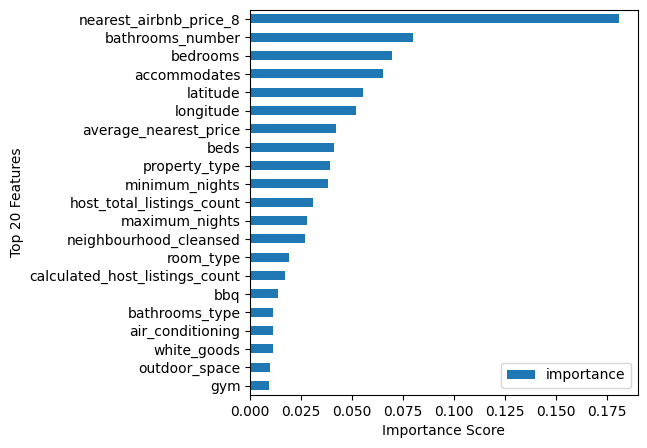

In [34]:
import matplotlib.pyplot as plt
feat_imp = pd.DataFrame({'importance':regressor.feature_importances_})  
feat_imp['feature'] = X_train_2.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)

feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp = feat_imp[25:46]
feat_imp.plot.barh(figsize=(5,5))
plt.xlabel('Importance Score')
plt.ylabel('Top 20 Features')
plt.show()

In [35]:
import math  
import sklearn.metrics
mse = sklearn.metrics.mean_squared_error(y_test_2, y_predict)  
mae = sklearn.metrics.mean_absolute_error(y_test_2, y_predict) 

rmse = math.sqrt(mse)  

# print("r2 score = ", regressor.score(X_test,y_test))
print("RMSE = ", rmse)
print("MAE = ", mae)

RMSE =  43.90872623978063
MAE =  29.336444444444446


In [36]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test_2)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_2.iloc[0,:])

#### Random Forest

Random Forest is an emsemble technique that is able to perform Regression tasks with the use of multiple decision trees and a technique that is called Bootstrap aggregation (Bagging). The idea behind this technique is to combine multiple results of decision trees in its prediction rather than replying on individual decision trees, thus reduces the variance.

Importance provides a score that indicates how useful or important each feature was in the construction of the decision trees within the model. The higher its relative importance, the more a variable is used to make key decisions within decision trees.

Therefore, feature importance can be used to interpret our data to understand the most important features that define our predictions. In this case, looking at the bar chart above, the predictor variable that is associated with a longer bar means that the variable has a higher importance in the Random Tree Regression Model in predicting price.